In [2]:
from project_paths import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, KFold, ParameterGrid
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

import xgboost

First, we use the test scores of the models evaluated on all the different sets to plot a figure that shows us their performance and then use that to decide the best model to handle this dataset. 

In [3]:
MODEL_EVALUATIONS = load_list_from_pkl(MODEL_EVALUATIONS_PICKLE)

In [30]:
error_bar_data = {}
models = []
for m in MODEL_EVALUATIONS.keys():
    models.append(m)
    error_bar_data[m] = {}
    error_bar_data[m]['data'] = np.array(MODEL_EVALUATIONS[m]['test_scores'])
    error_bar_data[m]['mean'] = np.mean(np.array(MODEL_EVALUATIONS[m]['test_scores']))
    error_bar_data[m]['std'] = np.std(np.array(MODEL_EVALUATIONS[m]['test_scores']))

x_pos = np.arange(len(models) + 1)
fbeta_15s = [error_bar_data[m]['mean'] for m in models]
error = [error_bar_data[m]['std'] for m in models]

# Baseline scores were calculated later, but being added here so that they go into the chart
models.append('baseline')
baseline_score, baseline_std = (0.07470127102519217, 0.2241038130755765)
fbeta_15s.append(baseline_score)
error.append(baseline_std)

model_names = {
    'logistic_regression': 'Logistic',
    'lasso': 'Lasso Regression',
    'xgboost': 'XGBoost',
    'random_forest': 'Random Forest',
    'ridge': 'Ridge Regression',
    'KNN': 'KNN',
    'baseline': 'Baseline',
}

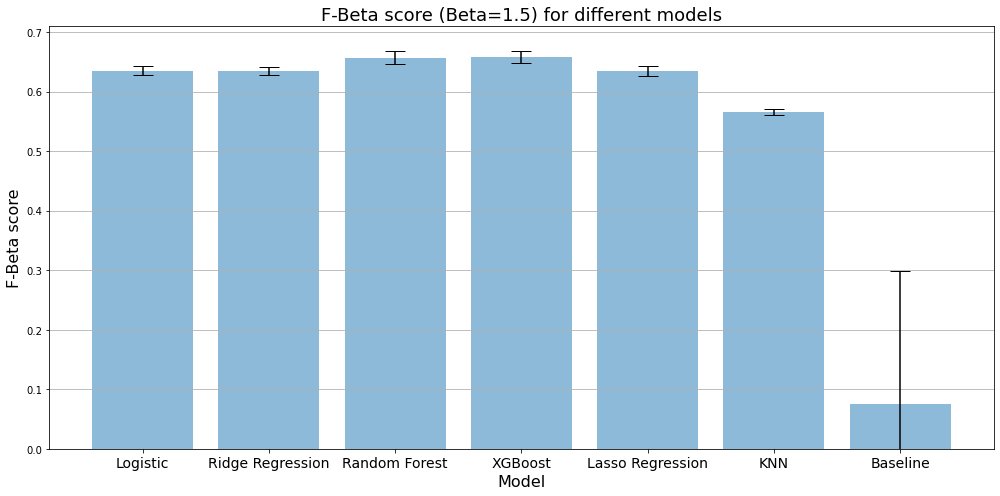

In [36]:
# Build the plot
fig, ax = plt.subplots(figsize=(14,7))
ax.bar(x_pos, fbeta_15s, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Model', fontsize=16)
ax.set_ylabel('F-Beta score', fontsize=16)
ax.set_xticks(x_pos)
ax.set_xticklabels([model_names[x] for x in models], fontsize=14)
ax.set_title('F-Beta score (Beta=1.5) for different models', fontsize=18)
ax.set_ylim(bottom=0.0)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig(figures_dir + 'bar_plot_with_error_bars.png')
plt.show()

The XGBoost model had the highest test set performance and was chosen as the model of choice. The best set of parameters were selected as the parameters that performed the best on a holdout set.

In [19]:
# Preprocessor
onehot_ftrs = load_list_from_pkl('onehot_ftrs.pkl')
minmax_ftrs = load_list_from_pkl('minmax_ftrs.pkl')
standard_ftrs = load_list_from_pkl('standard_ftrs.pkl')

preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs), 
                 ('minmax', MinMaxScaler(), minmax_ftrs),
                 ('standard', StandardScaler(), standard_ftrs),])

In [20]:
# def find_best_model_on_test_old(X_holdout, y_holdout, best_models):
#     """
#     Accepts best candidate configurations for a given ML model, 
#     runs them across random states on holdout data 
#     and returns results of best one 
#     (Best is found as model which has highest mean fbeta score across random states. 
#     For this model, we return the mean and stdev of fbeta scores across random states.)
#     """
#     BETA = 1.5
#     random_states = [x*5 for x in list(range(5))]
#     models_scores = np.zeros((len(random_states), len(best_models)))
#     # Populate scores for each random state for each model
#     for rs_ix, RANDOM_STATE in enumerate(random_states):
#         X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, 
#                                             train_size = 0.8, random_state=RANDOM_STATE)
#         for m_ix, m in enumerate(best_models):
#             X_train_prep = preprocessor.fit_transform(X_train)
#             X_test_prep = preprocessor.transform(X_test)
#             feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
#                         preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
#             df_train = pd.DataFrame(data=X_train, columns = feature_names)
#             df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

#             eval_set = [(df_test, y_test)]
#             m.fit(df_train, y_train,
#                     early_stopping_rounds=50, eval_set=eval_set, verbose=False)
#             y_test_pred = m.predict(df_test, ntree_limit=m.best_ntree_limit)
            
#             models_scores[rs_ix, m_ix] = fbeta_score(y_test, y_test_pred, beta=BETA)
    
#     model_wise_scores = models_scores.mean(axis=0)
#     best_model = best_models[np.argmax(model_wise_scores)]
#     best_score = np.max(model_wise_scores)
#     random_state_wise_stdev = np.mean(models_scores.std(axis=1))
#     return best_model, best_score, random_state_wise_stdev, model_wise_scores

# best_model, best_score, random_state_wise_stdev, model_wise_scores = find_best_model_on_test_old(X_other, y_other,
#                                                                             X_holdout, y_holdout, 
#                                                                           MODEL_EVALUATIONS['xgboost']['best_models'])

In [21]:
X_other = load_list_from_pkl('X_other.pkl')
y_other = load_list_from_pkl('y_other.pkl')
X_holdout = load_list_from_pkl('X_holdout.pkl')
y_holdout = load_list_from_pkl('y_holdout.pkl')

In [22]:
# Finding the best XGB boost model by checking on Test
best_models = MODEL_EVALUATIONS['xgboost']['best_models']

BETA = 1.5
# Populate scores for each random state for each model
random_states = [x*5 for x in list(range(5))]
models_scores = np.zeros((len(random_states), len(best_models)))
# Populate scores for each random state for each model
X_train_prep = preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_holdout)
y_train = y_other
y_test = y_holdout
feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)
for rs_ix, RANDOM_STATE in enumerate(random_states):
    for m_ix, m in enumerate(best_models):
        eval_set = [(df_test, y_test)]
        m.random_state=RANDOM_STATE
        m.fit(df_train, y_train, 
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)
        y_test_pred = m.predict(df_test, ntree_limit=m.best_ntree_limit)
        models_scores[rs_ix, m_ix] = fbeta_score(y_test, y_test_pred, beta=BETA)

model_wise_scores = models_scores.mean(axis=0)
best_model = best_models[np.argmax(model_wise_scores)]
best_score = np.max(model_wise_scores)
random_state_wise_stdev = np.mean(models_scores.std(axis=1))

[09:45:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [23]:
save_list_to_pkl(best_model, 'xgb_best_model.pkl')

In [24]:
model_wise_scores, best_model, best_score, random_state_wise_stdev

(array([0.65680427, 0.65660198, 0.65639445, 0.65672174, 0.65496105,
        0.66185371, 0.6590595 , 0.65444343, 0.65959552, 0.65455409]),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9,
               eval_metric=make_scorer(fbeta_score, beta=1.5), gamma=0,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=7, num_parallel_tree=1, random_state=20,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=25,
               subsample=0.66, tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 0.6618537125677438,
 0.002274983649742198)

### Calculating baseline scores

In [26]:
from sklearn.dummy import DummyClassifier
random_states = [x*5 for x in list(range(10))]
baseline_scores = []
dummy_clf = DummyClassifier(strategy="most_frequent")
for RANDOM_STATE in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, train_size = 0.6, random_state=RANDOM_STATE)
    dummy_clf.fit(X_train, y_train)
    y_test_preds = dummy_clf.predict(X_test)
    baseline_scores.append(fbeta_score(y_test, y_test_preds, beta=BETA))

baseline_scores = np.array(baseline_scores)
print("Baseline model F beta scores mean and stdev")
baseline_scores.mean(), baseline_scores.std()

Baseline model F beta scores mean and stdev


(0.07470127102519217, 0.2241038130755765)

### ROC Curve & Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Finding the best XGB boost model by checking on Test
best_models = MODEL_EVALUATIONS['xgboost']['best_models']
random_states = [x*5 for x in list(range(5))]
best_model_scores = []

confusion_matrices = []
tprs = []
fprs = []
for RANDOM_STATE in random_states:
    X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_other, y_other, train_size=0.8, random_state=RANDOM_STATE)

    # Populate scores for each random state for each model
    X_train_prep = preprocessor.fit_transform(X_train_eval)
    X_test_prep = preprocessor.transform(X_test_eval)
    y_train = y_train_eval
    y_test = y_test_eval
    feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
                preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
    df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
    df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

    eval_set = [(df_test, y_test)]
    best_model.fit(df_train, y_train,
            early_stopping_rounds=50, eval_set=eval_set, verbose=False)
    y_test_pred = best_model.predict(df_test, ntree_limit=m.best_ntree_limit)
    best_model_scores.append(fbeta_score(y_test, y_test_pred, beta=BETA))
    
    C = confusion_matrix(y_test, y_test_pred)
    C_normal = confusion_matrix(y_test, y_test_pred, normalize='true')
    confusion_matrices.append(C_normal)

    y_test_pred_prob = best_model.predict_proba(df_test, ntree_limit=m.best_ntree_limit)
    pred_prob_class1 = y_test_pred_prob[:, 1]
    fpr = np.zeros(len(y_test_pred_prob))
    tpr = np.zeros(len(y_test_pred_prob))

    p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

    for i in range(len(p_crits)):
        p_crit = p_crits[i]

        y_pred = np.zeros(len(y_test_pred_prob))
        y_pred[pred_prob_class1 < p_crit] = 0
        y_pred[pred_prob_class1 >= p_crit] = 1

        tpr[i] = C[1,1]/(C[1,0]+C[1,1])
        fpr[i] = C[0,1]/(C[0,0]+C[0,1])
    tprs.append(tpr)
    fprs.append(fpr)

[10:04:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [268]:
print("Fitted model F beta scores mean and stdev")
np.array(best_model_scores).mean(), np.array(best_model_scores).std()

Fitted model F beta scores mean and stdev


(0.6622293537482493, 0.005129711778423147)

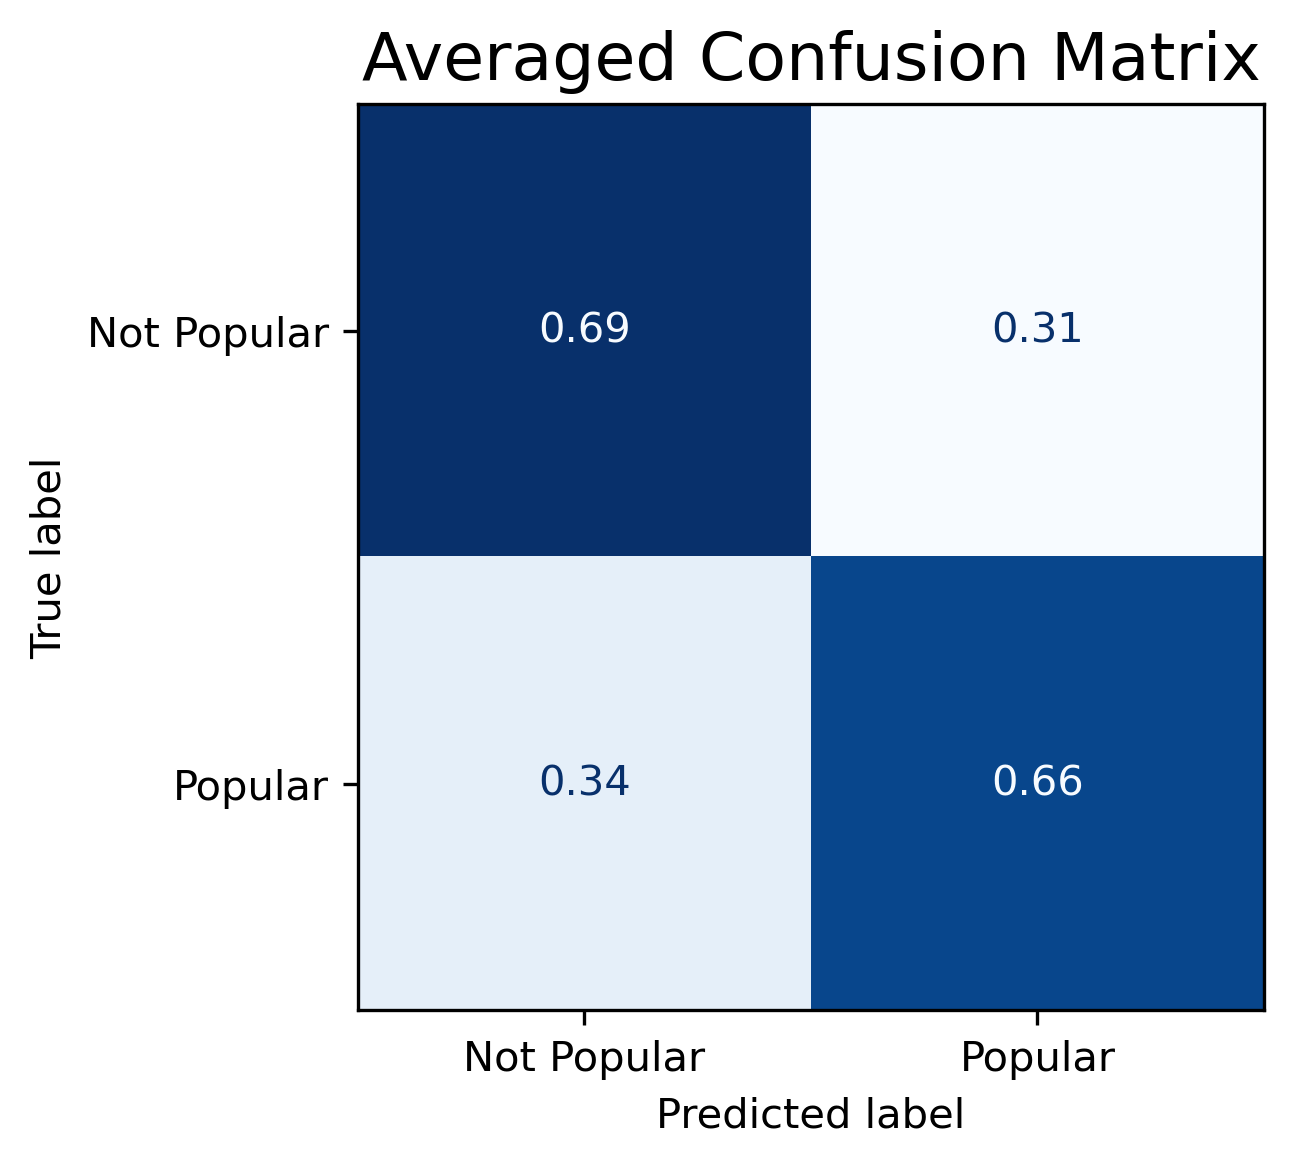

<Figure size 1200x900 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [269]:
averaged_confusion_mat = np.zeros((2, 2))
averaged_confusion_mat[0,0] = np.mean([a[0,0] for a in confusion_matrices])
averaged_confusion_mat[0,1] = np.mean([a[0,1] for a in confusion_matrices])
averaged_confusion_mat[1,0] = np.mean([a[1,0] for a in confusion_matrices])
averaged_confusion_mat[1,1] = np.mean([a[1,1] for a in confusion_matrices])

# cm = confusion_matrix(y_test, y_test_pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=averaged_confusion_mat,
                               display_labels=["Not Popular", "Popular"])
disp.plot(colorbar=False, cmap="Blues")
plt.title("Averaged Confusion Matrix", fontsize=16)
plt.figure(figsize=(4, 3))
plt.rcParams["figure.dpi"] = 300
plt.show()
plt.savefig(figures_dir + 'confusion_mat.png')

In [ ]:
X_train_prep = preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_holdout)
y_train = y_other
y_test = y_holdout

feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

eval_set = [(df_test, y_test)]
best_model.fit(df_train, y_train,
        early_stopping_rounds=50, eval_set=eval_set, verbose=False)
y_test_pred = best_model.predict(df_test, ntree_limit=m.best_ntree_limit)

C = confusion_matrix(y_test, y_test_pred)
C_normal = confusion_matrix(y_test, y_test_pred, normalize='true')
confusion_matrices.append(C_normal)

y_test_pred_prob = best_model.predict_proba(df_test, ntree_limit=m.best_ntree_limit)
pred_prob_class1 = y_test_pred_prob[:, 1]
fpr = np.zeros(len(y_test_pred_prob))
tpr = np.zeros(len(y_test_pred_prob))

p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

for i in range(len(p_crits)):
    p_crit = p_crits[i]

    y_pred = np.zeros(len(y_test_pred_prob))
    y_pred[pred_prob_class1 < p_crit] = 0
    y_pred[pred_prob_class1 >= p_crit] = 1

    tpr[i] = C[1,1]/(C[1,0]+C[1,1])
    fpr[i] = C[0,1]/(C[0,0]+C[0,1])
tprs.append(tpr)
fprs.append(fpr)

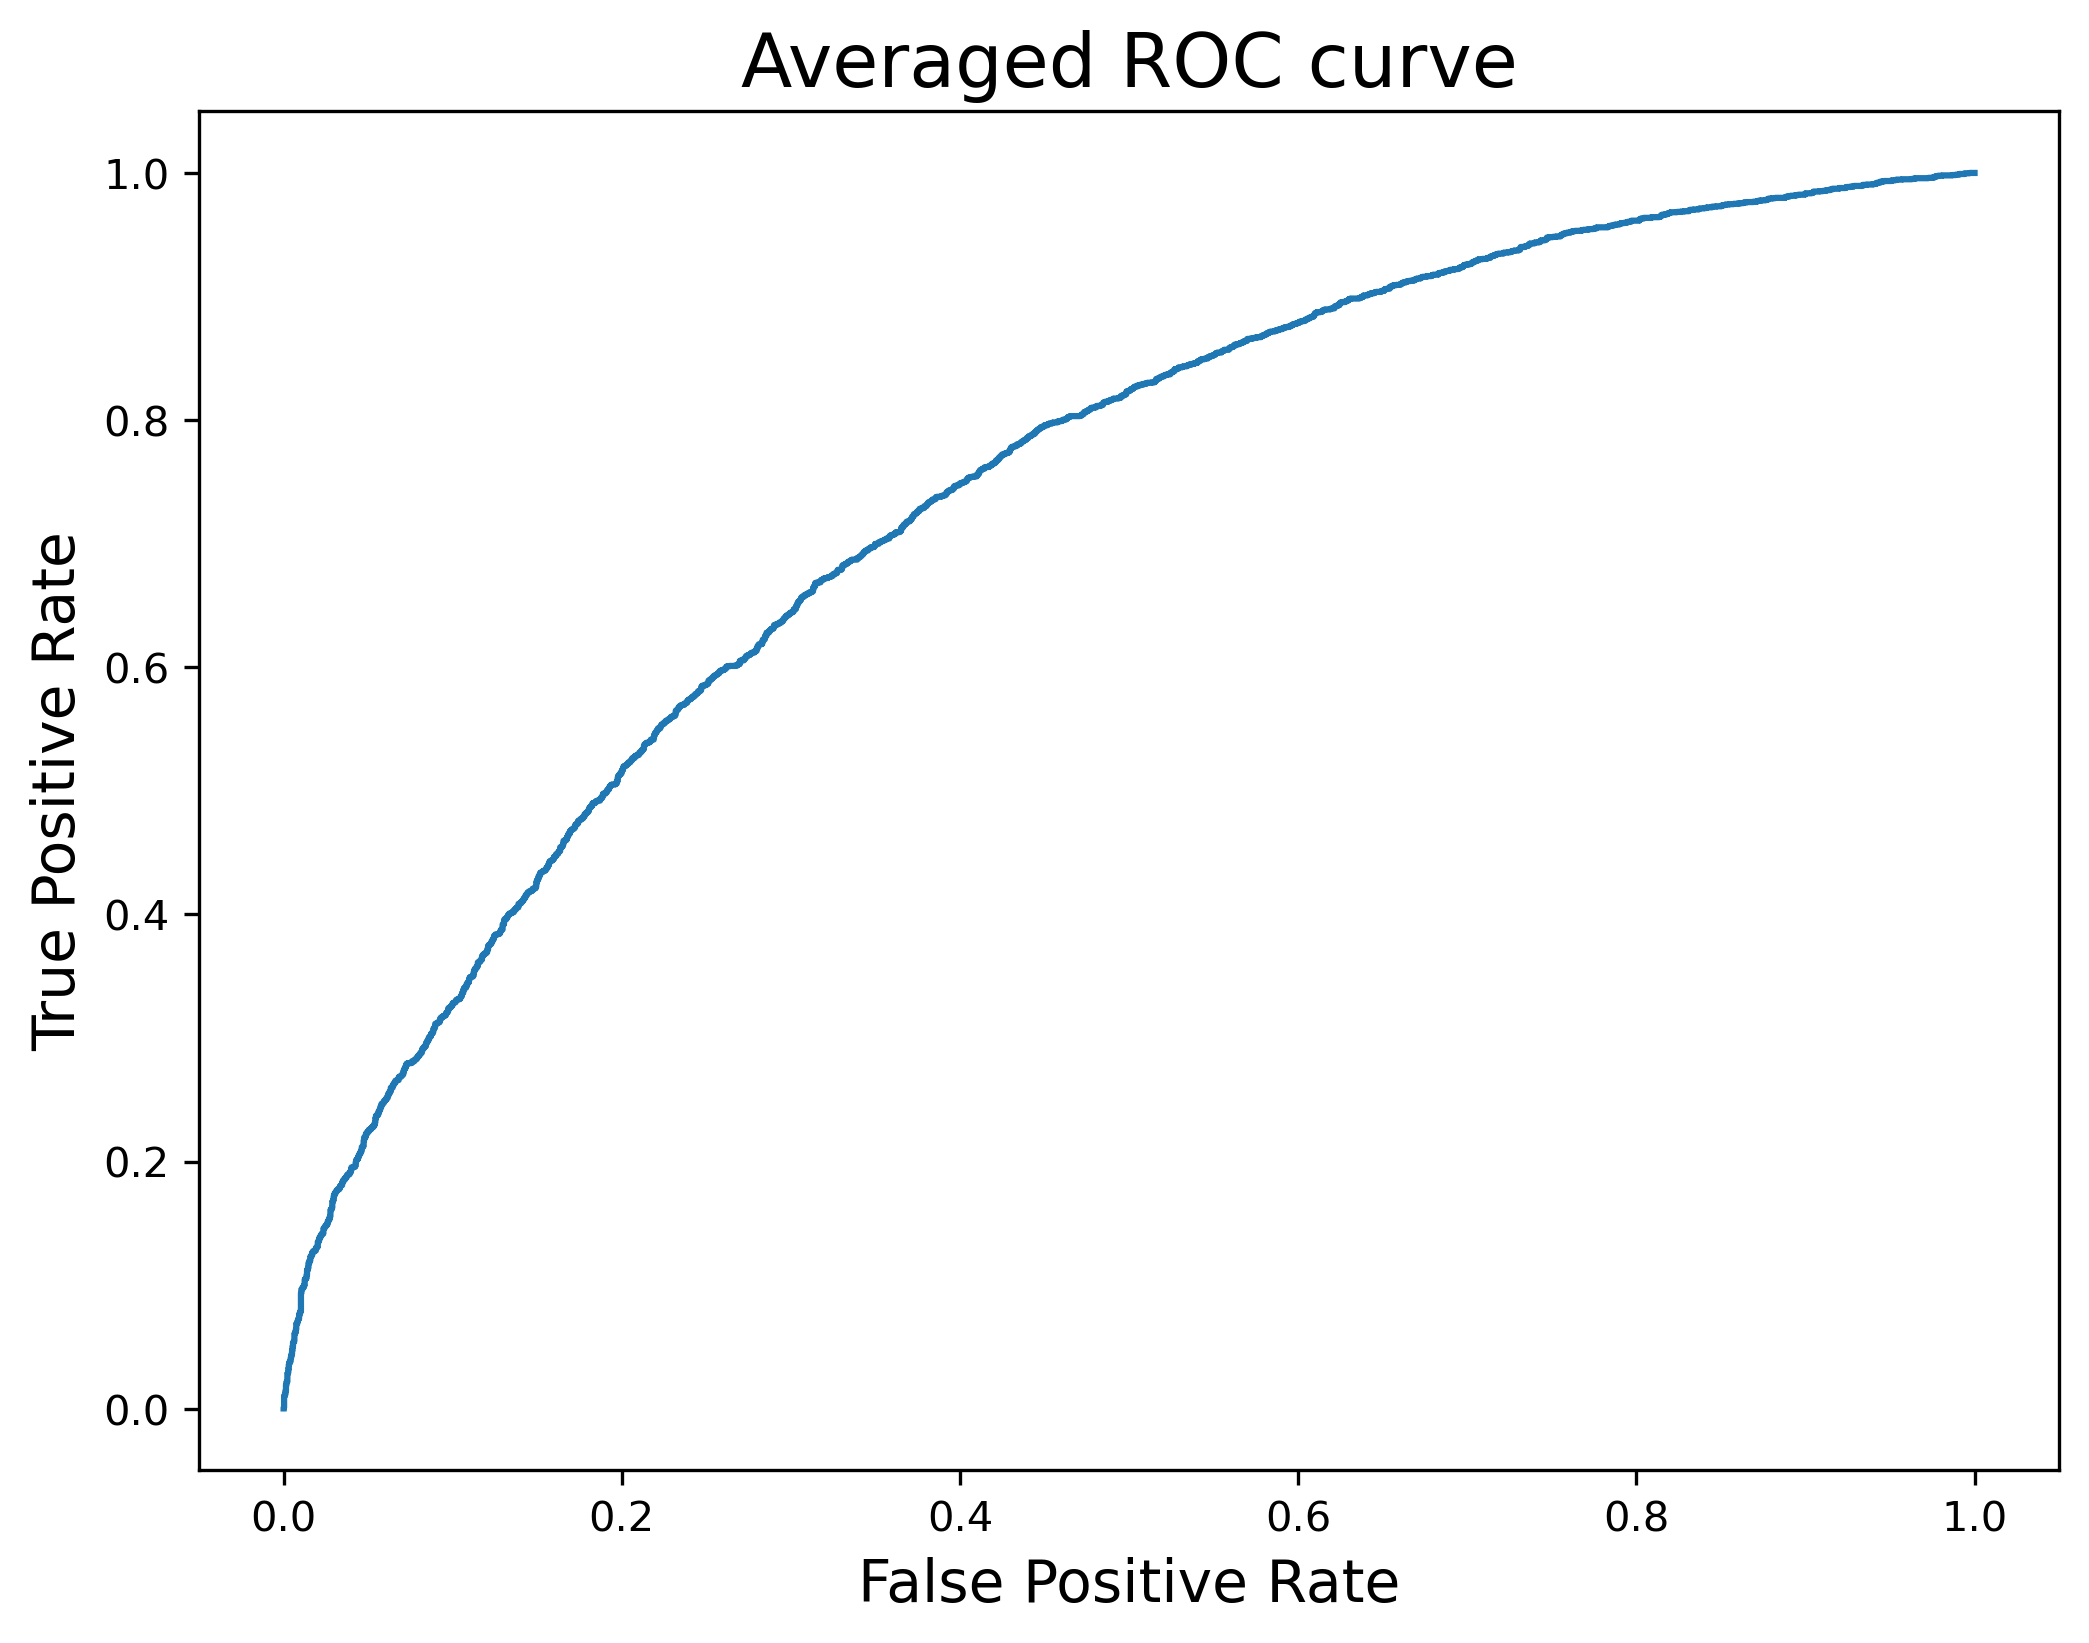

<Figure size 1800x1200 with 0 Axes>

In [252]:
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Averaged ROC curve', fontsize=18)
plt.rcParams["figure.dpi"] = 300
plt.show()
plt.savefig(figures_dir + 'roc_curve.png')

### Finding hyperparameter stats

In [12]:
vars(MODEL_EVALUATIONS['xgboost']['best_models'][0])['n_estimators']

1000

In [30]:
hyperparams_map = {
    'lasso': ['C'],
    'ridge': ['C'],
    'random_forest': ['max_features', 'max_depth'],
    'xgboost': ['n_estimators', 'max_depth'],
    'KNN': ['n_neighbors'],
}

for k in hyperparams_map.keys():
    params = hyperparams_map[k]
    best_models = MODEL_EVALUATIONS[k]['best_models']
    for p in params:
        if k == 'xgboost':
            best_params = [vars(mod)[p] for mod in best_models]
        else:
            best_params = [vars(mod[1])[p] for mod in best_models]
        mn = np.mean([x for x in best_params if x is not None])
        s = np.std([x for x in best_params if x is not None])
        print(k, p, "| mean: ", mn, "std: ", s)
        print()


lasso C | mean:  1.0899999999999999 std:  2.9699999999999998

ridge C | mean:  302.04999999999995 std:  456.93085089540625

random_forest max_features | mean:  0.5357142857142857 std:  0.08748177652797065

random_forest max_depth | mean:  25.0 std:  0.0

xgboost n_estimators | mean:  800.0 std:  244.94897427831782

xgboost max_depth | mean:  3.0 std:  0.0

KNN n_neighbors | mean:  14.5 std:  28.5

